In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os
from mplfinance.original_flavor import candlestick_ohlc
import pyupbit 
import ccxt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
import os 
import time 
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns

PyTorch version 1.7.1 available.
TensorFlow version 2.5.0 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [42]:
btc_2019 = pd.read_csv("data_5m/2019_BTCUSDT.csv") 
btc_2020 = pd.read_csv("data_5m/2020_BTCUSDT.csv") 
btc_2021 = pd.read_csv("data_5m/2021_BTCUSDT.csv") 
btc_2022 = pd.read_csv("data_5m/2022_BTCUSDT.csv") 

eth_2019 = pd.read_csv("data_5m/2019_ETHUSDT.csv") 
eth_2020 = pd.read_csv("data_5m/2020_ETHUSDT.csv") 
eth_2021 = pd.read_csv("data_5m/2021_ETHUSDT.csv") 
eth_2022 = pd.read_csv("data_5m/2022_ETHUSDT.csv") 

btc_2019.shape, btc_2020.shape, btc_2021.shape, btc_2022.shape, eth_2019.shape, eth_2020.shape, eth_2021.shape, eth_2022.shape

((105291, 7),
 (105685, 7),
 (105448, 7),
 (11361, 7),
 (105291, 7),
 (105685, 7),
 (105448, 7),
 (11364, 7))

In [43]:
btc_train = pd.concat([btc_2019, btc_2020, btc_2021]) 
eth_train = pd.concat([eth_2019, eth_2020, eth_2021]) 

btc_val = btc_2022 
eth_val = eth_2022

btc_train.shape, eth_train.shape, btc_val.shape, eth_val.shape

((316424, 7), (316424, 7), (11361, 7), (11364, 7))

In [44]:
def process(df): 
    binance = ccxt.binance() 
    dates = df['Open Time'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'0'})
    return df

In [45]:
btc_train = process(btc_train) 
eth_train = process(eth_train) 

btc_val = process(btc_val) 
eth_val = process(eth_val)

In [46]:
btc_train = btc_train.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})

eth_train = eth_train.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})


btc_train = btc_train.drop(columns={'Open Time'}) 
eth_train = eth_train.drop(columns={'Open Time'})
full_df = btc_train.join(eth_train.set_index('datetime'), on='datetime') 

full_df = full_df.dropna() 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume
0,3701.23,3703.72,3695.00,3696.32,85.572181,2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705
1,3696.30,3697.24,3689.88,3692.34,62.296581,2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843
2,3692.34,3698.93,3692.34,3697.31,43.105333,2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337
3,3697.91,3698.75,3693.00,3693.00,48.551084,2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505
4,3693.44,3695.98,3690.92,3692.18,47.706443,2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218


In [47]:
minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_df['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_df['Minutes'] = minutes
full_df['Hours'] = hours
full_df['Days'] = days 
full_df['Months'] = months 

100%|██████████| 319572/319572 [02:34<00:00, 2063.28it/s]


In [48]:
full_df = full_df.drop(columns={'datetime'}) 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,3701.23,3703.72,3695.00,3696.32,85.572181,131.45,131.54,131.01,131.27,1269.12705,0,0,1,1
1,3696.30,3697.24,3689.88,3692.34,62.296581,131.26,131.35,131.12,131.29,1601.91843,5,0,1,1
2,3692.34,3698.93,3692.34,3697.31,43.105333,131.27,131.36,131.19,131.31,560.54337,10,0,1,1
3,3697.91,3698.75,3693.00,3693.00,48.551084,131.30,131.36,131.25,131.30,651.89505,15,0,1,1
4,3693.44,3695.98,3690.92,3692.18,47.706443,131.26,131.44,131.25,131.28,500.58218,20,0,1,1


# Feature Engineering for train data + create train dataloader

In [49]:
def differencing(df, lookback=121, epsilon=1e-10): 
    columns = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume", 
               "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume"]
    for col in columns: 
        feature_values = df[col].values  
        d = {} 
        for i in range(1, lookback): 
            d['{}_Differenced_{}'.format(col, i)] = []
        for i in tqdm(range(df.shape[0]), position=0, leave=True): 
            if i < lookback: 
                for j in range(1, lookback): 
                    d['{}_Differenced_{}'.format(col, j)].append(None)
            else: 
                for j in range(1, lookback): 
                    if col == "BTC Volume" or col == "ETH Volume": 
                        # simple differencing for volume to prevent zero division
                        ret = feature_values[i] / (feature_values[i-j] + epsilon)
                    else: 
                        ret = feature_values[i] / feature_values[i-j] 
                    d['{}_Differenced_{}'.format(col, j)].append(ret) 
        for key, value in d.items():
            df[key] = value
    return df 


def feature_engineering(df): 
    print("===== Feature Engineering =====")
    windows = [5, 10, 20, 60, 120]
    
    for window in windows: 
        df['BTC_Open_ma{}'.format(window)] = df['BTC Open'].rolling(window).mean() 
        df['BTC_Open_ma{}_ratio'.format(window)] = (df['BTC Open'] - df['BTC_Open_ma{}'.format(window)]) / df['BTC_Open_ma{}'.format(window)]

        df['BTC_High_ma{}'.format(window)] = df['BTC High'].rolling(window).mean()
        df['BTC_High_ma{}_ratio'.format(window)] = (df['BTC High'] - df['BTC_High_ma{}'.format(window)]) / df['BTC_High_ma{}'.format(window)]

        df['BTC_Low_ma{}'.format(window)] = df['BTC Low'].rolling(window).mean() 
        df['BTC_Low_ma{}_ratio'.format(window)] = (df['BTC Low'] - df['BTC_Low_ma{}'.format(window)]) / df['BTC_Low_ma{}'.format(window)]
        
        df['BTC_Close_ma{}'.format(window)] = df['BTC Close'].rolling(window).mean() 
        df['BTC_Close_ma{}_ratio'.format(window)] = (df['BTC Close'] - df['BTC_Close_ma{}'.format(window)]) / df['BTC_Close_ma{}'.format(window)]

        df['BTC_Volume_ma{}'.format(window)] = df['BTC Volume'].rolling(window).mean() 
        df['BTC_Volume_ma{}_ratio'.format(window)] = (df['BTC Volume'] - df['BTC_Volume_ma{}'.format(window)]) / df['BTC_Volume_ma{}'.format(window)]
        
        df['ETH_Open_ma{}'.format(window)] = df['ETH Open'].rolling(window).mean() 
        df['ETH_Open_ma{}_ratio'.format(window)] = (df['ETH Open'] - df['ETH_Open_ma{}'.format(window)]) / df['ETH_Open_ma{}'.format(window)] 
        
        df['ETH_High_ma{}'.format(window)] = df['ETH High'].rolling(window).mean() 
        df['ETH_High_ma{}_ratio'.format(window)] = (df['ETH High'] - df['ETH_High_ma{}'.format(window)]) / df['ETH_High_ma{}'.format(window)] 
        
        df['ETH_Low_ma{}'.format(window)] = df['ETH Low'].rolling(window).mean() 
        df['ETH_Low_ma{}_ratio'.format(window)] = (df['ETH Low'] - df['ETH_Low_ma{}'.format(window)]) / df['ETH_Low_ma{}'.format(window)] 
        
        df['ETH_Close_ma{}'.format(window)] = df['ETH Close'].rolling(window).mean() 
        df['ETH_Close_ma{}_ratio'.format(window)] = (df['ETH Close'] - df['ETH_Close_ma{}'.format(window)]) / df['ETH_Close_ma{}'.format(window)]

        df['ETH_Volume_ma{}'.format(window)] = df['ETH Volume'].rolling(window).mean() 
        df['ETH_Volume_ma{}_ratio'.format(window)] = (df['ETH Volume'] - df['ETH_Volume_ma{}'.format(window)]) / df['ETH_Volume_ma{}'.format(window)]
    
    # df = differencing(df)  
    df = df.dropna() 
    
    print("===== Create Target Array =====")
    K = 6 # forecasting window 
    targets = []
    open_values = df['BTC Open'].values 
    for i in tqdm(range(open_values.shape[0] - K)):
        target = [] 
        for j in range(1,K+1): 
            ret = open_values[i+j] / open_values[i] 
            target.append(ret) 
        targets.append(target) 

    print("===== Create Future Discrete Array =====")
    future_discs = []
    disc_values = df[["Minutes","Hours","Days","Months"]] 
    
    for i in tqdm(range(disc_values.shape[0] - K)):
        future_disc = [] 
        for j in range(1,K+1):
            future_disc.append(disc_values.iloc[i+j,:])
        future_discs.append(future_disc)
    
    print("===== Get rid of unnecessary columns for training or validation =====")
    df = df.iloc[:-K] 
    remove_cols = ["BTC Open",
                   "BTC High",
                   "BTC Low", 
                   "BTC Close", 
                   "BTC Volume", 
                   "ETH Open", 
                   "ETH High", 
                   "ETH Low", 
                   "ETH Close", 
                   "ETH Volume"]
    for ticker in ["BTC","ETH"]: 
        for chart_info in ["Open", "High", "Low", "Close", "Volume"]: 
            for w in [5,10,20,60,120]:
                remove_cols.append("{}_{}_ma{}".format(ticker, chart_info, w)) 
    
    relevant_cols = [] 
    cols = df.columns 
    for col in cols: 
        if col not in remove_cols: 
            relevant_cols.append(col) 
    
    df = df[relevant_cols] 
    print("Done!")
    return df, targets, future_discs  



In [50]:
train_df, train_targets, train_future_discs = feature_engineering(full_df)

===== Feature Engineering =====
===== Create Target Array =====


100%|██████████| 319415/319415 [00:01<00:00, 244482.12it/s]


===== Create Future Discrete Array =====


100%|██████████| 319415/319415 [05:03<00:00, 1052.50it/s]

===== Get rid of unnecessary columns for training or validation =====
Done!


In [51]:
train_df.shape[0], len(train_targets), len(train_future_discs)

(319415, 319415, 319415)

In [52]:
K = 6 # forecasting window 

disc_cols = ["Minutes", "Hours", "Days", "Months"] 
cont_cols = [] 
cols = train_df.columns 
for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
train_cont = train_df[cont_cols].values 
train_disc = train_df[disc_cols].values

train_cont = torch.tensor(train_cont, dtype=torch.float32) 
train_disc = torch.tensor(train_disc, dtype=torch.float32) 

num_cont_features = len(cont_cols)
num_disc_features = len(disc_cols)

train_cont = torch.reshape(train_cont, (-1, 1, num_cont_features, 1)) 
train_disc = torch.reshape(train_disc, (-1, 1, num_disc_features)) 

train_targets = torch.tensor(train_targets, dtype=torch.float32) 
train_targets = torch.reshape(train_targets, (-1, K, 1))  

train_future_discs = torch.tensor(train_future_discs, dtype=torch.float32) 
train_future_discs = torch.reshape(train_future_discs, (-1, K, num_disc_features)) 


train_cont.shape, train_targets.shape, train_disc.shape, train_future_discs.shape 

(torch.Size([319415, 1, 50, 1]),
 torch.Size([319415, 6, 1]),
 torch.Size([319415, 1, 4]),
 torch.Size([319415, 6, 4]))

In [53]:
BATCH_SIZE = 128

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

train_dataset = CustomDataset(train_cont, train_disc, train_targets, train_future_discs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 

# Feature Engineering for val data + Create Val DataLoader

In [54]:
btc_val = btc_val.rename(columns={'Open':"BTC Open",
                                  'High':"BTC High", 
                                    'Low':"BTC Low",
                                    'Close':"BTC Close",
                                    'Volume':"BTC Volume"})

eth_val = eth_val.rename(columns={'Open':"ETH Open",
                                  'High':"ETH High", 
                                  'Low':"ETH Low",
                                  'Close':"ETH Close",
                                  'Volume':"ETH Volume"})


btc_val = btc_val.drop(columns={'Open Time'}) 
eth_val = eth_val.drop(columns={'Open Time'})
full_val = btc_val.join(eth_val.set_index('datetime'), on='datetime') 

full_val = full_val.dropna() 
full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume
0,46216.93,46391.49,46208.37,46321.34,185.67558,2022-01-01 00:00:00,3676.22,3695.41,3676.22,3690.09,1363.4570
1,46321.34,46527.26,46280.00,46371.11,123.43577,2022-01-01 00:05:00,3690.12,3705.90,3686.70,3696.55,862.5494
2,46369.79,46394.00,46276.22,46332.51,77.54574,2022-01-01 00:10:00,3696.55,3699.81,3686.70,3691.90,753.5524
3,46332.52,46332.52,46236.27,46293.90,101.14315,2022-01-01 00:15:00,3691.90,3693.35,3685.83,3689.51,438.4134
4,46295.42,46421.27,46286.25,46395.53,135.32479,2022-01-01 00:20:00,3689.51,3699.58,3688.60,3699.45,372.5966


In [55]:
val_minutes = [] 
val_hours = []
val_days = [] 
val_months = [] 
for dt in tqdm(full_val['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    val_minutes.append(minute)
    val_hours.append(hour) 
    val_days.append(day) 
    val_months.append(month)
    
full_val['Minutes'] = val_minutes
full_val['Hours'] = val_hours
full_val['Days'] = val_days 
full_val['Months'] = val_months 

100%|██████████| 11473/11473 [00:05<00:00, 2062.65it/s]


In [56]:
full_val = full_val.drop(columns={'datetime'}) 
full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,46216.93,46391.49,46208.37,46321.34,185.67558,3676.22,3695.41,3676.22,3690.09,1363.4570,0,0,1,1
1,46321.34,46527.26,46280.00,46371.11,123.43577,3690.12,3705.90,3686.70,3696.55,862.5494,5,0,1,1
2,46369.79,46394.00,46276.22,46332.51,77.54574,3696.55,3699.81,3686.70,3691.90,753.5524,10,0,1,1
3,46332.52,46332.52,46236.27,46293.90,101.14315,3691.90,3693.35,3685.83,3689.51,438.4134,15,0,1,1
4,46295.42,46421.27,46286.25,46395.53,135.32479,3689.51,3699.58,3688.60,3699.45,372.5966,20,0,1,1


In [57]:
val_df, val_targets, val_future_discs = feature_engineering(full_val) 

===== Feature Engineering =====
===== Create Target Array =====


100%|██████████| 11348/11348 [00:00<00:00, 308296.44it/s]


===== Create Future Discrete Array =====


100%|██████████| 11348/11348 [00:10<00:00, 1069.52it/s]

===== Get rid of unnecessary columns for training or validation =====
Done!


In [58]:
val_df.shape[0], len(val_targets), len(val_future_discs) 

(11348, 11348, 11348)

In [59]:
K = 6 # forecasting window 

disc_cols = ["Minutes", "Hours", "Days", "Months"] 
cont_cols = [] 
cols = train_df.columns 
for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
val_cont = val_df[cont_cols].values 
val_disc = val_df[disc_cols].values

val_cont = torch.tensor(val_cont, dtype=torch.float32) 
val_disc = torch.tensor(val_disc, dtype=torch.float32) 

num_cont_features = len(cont_cols) 
num_disc_features = len(disc_cols)

val_cont = torch.reshape(val_cont, (-1, 1, num_cont_features, 1)) 
val_disc = torch.reshape(val_disc, (-1, 1, num_disc_features))  

val_targets = torch.tensor(val_targets, dtype=torch.float32) 
val_targets = torch.reshape(val_targets, (-1, K, 1))  

val_future_discs = torch.tensor(val_future_discs, dtype=torch.float32) 
val_future_discs = torch.reshape(val_future_discs, (-1, K, num_disc_features)) 


val_cont.shape, val_targets.shape, val_disc.shape, val_future_discs.shape 

(torch.Size([11348, 1, 50, 1]),
 torch.Size([11348, 6, 1]),
 torch.Size([11348, 1, 4]),
 torch.Size([11348, 6, 4]))

In [60]:
val_dataset = CustomDataset(val_cont, val_disc, val_targets, val_future_discs)  
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 

# Define Temporal Fusion Transformer

In [61]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))

In [62]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

In [63]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

In [64]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        '''
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 

        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        

In [65]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

In [66]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

In [67]:
features = train_cont.shape[2]

model = TFN(n_var_past_cont = features,
            n_var_future_cont = 0, 
            n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
            n_var_future_disc = [60, 24, 32, 13],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=8640, out_features=54, bias=True)
      (fc1): Linear(in_features=8640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=54, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=54, out_features=54, bias=True)
        (fc2): Linear(in_features=54, out_features=54, bias=True)
      )
      (norm): LayerNorm((54,), eps=1e-05, elementwise_aff

In [68]:
device = torch.device('cuda')

epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) 

train_losses, val_losses = [], []  

criterion = nn.MSELoss()  

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [69]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(tqdm(data_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device)
        
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True) 
        with torch.no_grad():
            net_out, vs_weights = model(past_cont, past_disc, None, future_disc)  
        loss = criterion(net_out, target_seq)
        eval_loss += loss.item() 
    avg_val_loss = eval_loss / len(data_dataloader)    
    return avg_val_loss, net_out, vs_weights

# for processing discrete features 
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

In [70]:
for i in range(epochs): 
    print("")
    print("======= Epoch {:} / {:} =======".format(i+1, epochs))
    print("Training...") 
    total_loss = 0 
    model.train() 
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)):
        if step%100 == 0 and not step == 0:
            print("current average loss = {:.5f}".format(total_loss / step))
                
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13])  
                
        optimizer.zero_grad() 
        net_out, vs_weights = model(past_cont, past_disc, None, future_disc) 
        
        loss = criterion(net_out, target_seq) 
        total_loss += loss.item() 
        loss.backward() # back propagation 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping 
        optimizer.step() 
        scheduler.step() 
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  
    
    print("Validating...")
    model.eval() 
    val_loss, _, _ = evaluate(val_dataloader) 
    val_losses.append(val_loss) 
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint...") 
        torch.save(model.state_dict(), "TFT_feature_engineered_5mins_less_features.pt") 

print("") 
print("Training Complete!")


======= Epoch 1 / 50 =======
Training...


Iteration:   0%|          | 0/2496 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct f

current average loss = 0.19871


Iteration:   8%|▊         | 202/2496 [00:15<02:11, 17.45it/s]

current average loss = 0.10442


Iteration:  12%|█▏        | 302/2496 [00:21<02:05, 17.55it/s]

current average loss = 0.07155


Iteration:  16%|█▌        | 402/2496 [00:27<02:05, 16.70it/s]

current average loss = 0.05459


Iteration:  20%|██        | 502/2496 [00:32<01:51, 17.89it/s]

current average loss = 0.04419


Iteration:  24%|██▍       | 602/2496 [00:38<01:48, 17.44it/s]

current average loss = 0.03715


Iteration:  28%|██▊       | 702/2496 [00:44<01:42, 17.53it/s]

current average loss = 0.03206


Iteration:  32%|███▏      | 802/2496 [00:49<01:36, 17.47it/s]

current average loss = 0.02820


Iteration:  36%|███▌      | 902/2496 [00:55<01:36, 16.45it/s]

current average loss = 0.02518


Iteration:  40%|████      | 1002/2496 [01:01<01:25, 17.53it/s]

current average loss = 0.02274


Iteration:  44%|████▍     | 1102/2496 [01:07<01:19, 17.44it/s]

current average loss = 0.02074


Iteration:  48%|████▊     | 1202/2496 [01:13<01:15, 17.07it/s]

current average loss = 0.01906


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:07, 17.75it/s]

current average loss = 0.01763


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:01, 17.81it/s]

current average loss = 0.01640


Iteration:  60%|██████    | 1502/2496 [01:30<00:58, 17.08it/s]

current average loss = 0.01534


Iteration:  64%|██████▍   | 1602/2496 [01:36<00:53, 16.71it/s]

current average loss = 0.01440


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:44, 17.98it/s]

current average loss = 0.01357


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:38, 18.10it/s]

current average loss = 0.01283


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:34, 17.39it/s]

current average loss = 0.01217


Iteration:  80%|████████  | 2002/2496 [01:58<00:28, 17.54it/s]

current average loss = 0.01157


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:22, 17.85it/s]

current average loss = 0.01103


Iteration:  88%|████████▊ | 2202/2496 [02:10<00:16, 17.30it/s]

current average loss = 0.01054


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:10, 17.87it/s]

current average loss = 0.01009


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.52it/s]

current average loss = 0.00967


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.98it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.47it/s]


Saving Best Checkpoint...

======= Epoch 2 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:17, 17.47it/s]

current average loss = 0.00014


Iteration:   8%|▊         | 202/2496 [00:11<02:10, 17.52it/s]

current average loss = 0.00014


Iteration:  12%|█▏        | 302/2496 [00:17<02:02, 17.97it/s]

current average loss = 0.00013


Iteration:  16%|█▌        | 402/2496 [00:22<02:00, 17.33it/s]

current average loss = 0.00013


Iteration:  20%|██        | 502/2496 [00:28<01:53, 17.59it/s]

current average loss = 0.00012


Iteration:  24%|██▍       | 602/2496 [00:34<01:48, 17.40it/s]

current average loss = 0.00012


Iteration:  28%|██▊       | 702/2496 [00:40<01:40, 17.87it/s]

current average loss = 0.00012


Iteration:  32%|███▏      | 802/2496 [00:45<01:33, 18.09it/s]

current average loss = 0.00011


Iteration:  36%|███▌      | 902/2496 [00:51<01:29, 17.83it/s]

current average loss = 0.00011


Iteration:  40%|████      | 1002/2496 [00:56<01:24, 17.66it/s]

current average loss = 0.00011


Iteration:  44%|████▍     | 1102/2496 [01:02<01:17, 17.89it/s]

current average loss = 0.00011


Iteration:  48%|████▊     | 1202/2496 [01:08<01:18, 16.46it/s]

current average loss = 0.00010


Iteration:  52%|█████▏    | 1302/2496 [01:14<01:11, 16.76it/s]

current average loss = 0.00010


Iteration:  56%|█████▌    | 1402/2496 [01:20<01:04, 17.06it/s]

current average loss = 0.00010


Iteration:  60%|██████    | 1502/2496 [01:26<00:58, 17.06it/s]

current average loss = 0.00010


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:52, 17.02it/s]

current average loss = 0.00010


Iteration:  68%|██████▊   | 1702/2496 [01:38<00:46, 17.21it/s]

current average loss = 0.00010


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:38, 17.85it/s]

current average loss = 0.00009


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:33, 17.74it/s]

current average loss = 0.00009


Iteration:  80%|████████  | 2002/2496 [01:55<00:27, 17.74it/s]

current average loss = 0.00009


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:25, 15.57it/s]

current average loss = 0.00009


Iteration:  88%|████████▊ | 2202/2496 [02:07<00:16, 17.64it/s]

current average loss = 0.00009


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:10, 18.24it/s]

current average loss = 0.00009


Iteration:  96%|█████████▌| 2402/2496 [02:18<00:06, 15.07it/s]

current average loss = 0.00008


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.21it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 43.71it/s]


Saving Best Checkpoint...

======= Epoch 3 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:22, 16.75it/s]

current average loss = 0.00005


Iteration:   8%|▊         | 202/2496 [00:12<02:28, 15.40it/s]

current average loss = 0.00005


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.31it/s]

current average loss = 0.00005


Iteration:  16%|█▌        | 402/2496 [00:23<02:02, 17.06it/s]

current average loss = 0.00005


Iteration:  20%|██        | 502/2496 [00:29<01:55, 17.28it/s]

current average loss = 0.00005


Iteration:  24%|██▍       | 602/2496 [00:35<02:02, 15.42it/s]

current average loss = 0.00005


Iteration:  28%|██▊       | 702/2496 [00:42<01:57, 15.32it/s]

current average loss = 0.00005


Iteration:  32%|███▏      | 802/2496 [00:49<01:46, 15.87it/s]

current average loss = 0.00005


Iteration:  36%|███▌      | 902/2496 [00:54<01:35, 16.63it/s]

current average loss = 0.00005


Iteration:  40%|████      | 1002/2496 [01:00<01:25, 17.55it/s]

current average loss = 0.00005


Iteration:  44%|████▍     | 1102/2496 [01:06<01:17, 17.94it/s]

current average loss = 0.00004


Iteration:  48%|████▊     | 1202/2496 [01:12<01:19, 16.35it/s]

current average loss = 0.00004


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:07, 17.76it/s]

current average loss = 0.00004


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:00, 18.17it/s]

current average loss = 0.00004


Iteration:  60%|██████    | 1502/2496 [01:29<00:57, 17.36it/s]

current average loss = 0.00004


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:50, 17.85it/s]

current average loss = 0.00004


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:44, 17.79it/s]

current average loss = 0.00004


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:40, 17.19it/s]

current average loss = 0.00004


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:34, 17.33it/s]

current average loss = 0.00004


Iteration:  80%|████████  | 2002/2496 [01:57<00:29, 16.96it/s]

current average loss = 0.00004


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:23, 16.96it/s]

current average loss = 0.00004


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:18, 16.29it/s]

current average loss = 0.00004


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:12, 15.60it/s]

current average loss = 0.00004


Iteration:  96%|█████████▌| 2402/2496 [02:22<00:06, 15.28it/s]

current average loss = 0.00004


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.84it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 47.31it/s]


Saving Best Checkpoint...

======= Epoch 4 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:10, 18.37it/s]

current average loss = 0.00003


Iteration:   8%|▊         | 202/2496 [00:11<02:08, 17.92it/s]

current average loss = 0.00003


Iteration:  12%|█▏        | 302/2496 [00:17<02:08, 17.03it/s]

current average loss = 0.00003


Iteration:  16%|█▌        | 402/2496 [00:22<01:56, 18.03it/s]

current average loss = 0.00003


Iteration:  20%|██        | 502/2496 [00:28<01:49, 18.20it/s]

current average loss = 0.00003


Iteration:  24%|██▍       | 602/2496 [00:33<01:47, 17.70it/s]

current average loss = 0.00003


Iteration:  28%|██▊       | 702/2496 [00:39<01:40, 17.80it/s]

current average loss = 0.00003


Iteration:  32%|███▏      | 802/2496 [00:44<01:33, 18.19it/s]

current average loss = 0.00003


Iteration:  36%|███▌      | 902/2496 [00:50<01:31, 17.45it/s]

current average loss = 0.00003


Iteration:  40%|████      | 1002/2496 [00:56<01:24, 17.63it/s]

current average loss = 0.00003


Iteration:  44%|████▍     | 1102/2496 [01:01<01:18, 17.69it/s]

current average loss = 0.00003


Iteration:  48%|████▊     | 1202/2496 [01:07<01:13, 17.68it/s]

current average loss = 0.00003


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:10, 16.91it/s]

current average loss = 0.00003


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:06, 16.47it/s]

current average loss = 0.00003


Iteration:  60%|██████    | 1502/2496 [01:25<00:56, 17.64it/s]

current average loss = 0.00003


Iteration:  64%|██████▍   | 1602/2496 [01:30<00:50, 17.77it/s]

current average loss = 0.00003


Iteration:  68%|██████▊   | 1702/2496 [01:36<00:44, 17.75it/s]

current average loss = 0.00003


Iteration:  72%|███████▏  | 1802/2496 [01:42<00:38, 18.09it/s]

current average loss = 0.00003


Iteration:  76%|███████▌  | 1902/2496 [01:47<00:33, 17.81it/s]

current average loss = 0.00003


Iteration:  80%|████████  | 2002/2496 [01:53<00:29, 16.84it/s]

current average loss = 0.00003


Iteration:  84%|████████▍ | 2102/2496 [01:59<00:23, 16.94it/s]

current average loss = 0.00003


Iteration:  88%|████████▊ | 2202/2496 [02:05<00:16, 17.45it/s]

current average loss = 0.00003


Iteration:  92%|█████████▏| 2302/2496 [02:11<00:11, 17.29it/s]

current average loss = 0.00003


Iteration:  96%|█████████▌| 2402/2496 [02:16<00:05, 17.80it/s]

current average loss = 0.00003


Iteration: 100%|██████████| 2496/2496 [02:22<00:00, 17.57it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 48.02it/s]



======= Epoch 5 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:11, 18.17it/s]

current average loss = 0.00003


Iteration:   8%|▊         | 202/2496 [00:11<02:05, 18.34it/s]

current average loss = 0.00003


Iteration:  12%|█▏        | 302/2496 [00:16<01:59, 18.32it/s]

current average loss = 0.00003


Iteration:  16%|█▌        | 402/2496 [00:22<01:55, 18.18it/s]

current average loss = 0.00003


Iteration:  20%|██        | 502/2496 [00:27<01:50, 18.12it/s]

current average loss = 0.00003


Iteration:  24%|██▍       | 602/2496 [00:33<01:43, 18.24it/s]

current average loss = 0.00003


Iteration:  28%|██▊       | 702/2496 [00:38<01:38, 18.22it/s]

current average loss = 0.00003


Iteration:  32%|███▏      | 802/2496 [00:44<01:32, 18.41it/s]

current average loss = 0.00003


Iteration:  36%|███▌      | 902/2496 [00:50<01:40, 15.79it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:31, 16.36it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:26, 16.18it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:14, 17.40it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:14<01:06, 17.89it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:01, 17.77it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<00:57, 17.42it/s]

current average loss = 0.00003


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:50, 17.85it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:36<00:44, 17.67it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:43, 15.80it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:34, 17.29it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:54<00:28, 17.37it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:00<00:22, 17.39it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:06<00:17, 16.85it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:11, 17.28it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:17<00:05, 17.81it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:23<00:00, 17.42it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 47.06it/s]



======= Epoch 6 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:16, 17.55it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:06, 18.20it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.30it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<02:01, 17.25it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:52, 17.74it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:47, 17.64it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:41, 17.72it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:35, 17.75it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:51<01:29, 17.74it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:24, 17.69it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:18, 17.84it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:13, 17.59it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:07, 17.61it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:01, 17.74it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<01:03, 15.65it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:54, 16.52it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:47, 16.70it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:41, 16.61it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:35, 16.60it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:55<00:28, 17.40it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:23, 17.12it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:20, 14.23it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:13, 14.47it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:06, 14.52it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.84it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 38.20it/s]



======= Epoch 7 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 17.04it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.38it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.31it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<02:02, 17.09it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:57, 16.92it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:51, 16.97it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:45, 16.94it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:38, 17.28it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:33, 17.10it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:48, 13.76it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:23, 16.68it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:14, 17.37it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:10, 16.93it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:00, 17.95it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:57, 17.32it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:55, 16.04it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:51, 15.55it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:41, 16.86it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:33, 17.69it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:27, 18.20it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:25, 15.55it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:19, 15.13it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:17<00:11, 16.32it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:23<00:05, 16.02it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:29<00:00, 16.70it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.97it/s]


Saving Best Checkpoint...

======= Epoch 8 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:10, 18.28it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:18, 16.58it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:24, 15.22it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:09, 16.21it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<01:55, 17.25it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:47, 17.61it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:44, 17.21it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:37, 17.40it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:30, 17.52it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:38, 15.23it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:22, 16.91it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:14, 17.37it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:08, 17.44it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:01, 17.66it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:57, 17.32it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:53, 16.82it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:45, 17.53it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:39, 17.48it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:34, 16.98it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:57<00:27, 17.71it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:22, 17.38it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:16, 17.84it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:12, 15.39it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 16.75it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.92it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 44.16it/s]


Saving Best Checkpoint...

======= Epoch 9 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 16.98it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:26, 15.68it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:15, 16.20it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:14, 15.57it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<01:58, 16.76it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:49, 17.26it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:42, 17.46it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:36, 17.63it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:31, 17.37it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:27, 17.06it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:22, 16.94it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:16, 16.92it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:11, 16.80it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:03, 17.19it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:56, 17.47it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:50, 17.70it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:45, 17.50it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:41, 16.91it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:40, 14.53it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:59<00:28, 17.63it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:21, 17.99it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:10<00:16, 17.51it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:10, 17.82it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.76it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.96it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.29it/s]



======= Epoch 10 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.25it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:32, 15.04it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:06, 17.32it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:02, 17.10it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<01:57, 17.01it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:47, 17.68it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:53, 15.84it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:40, 16.78it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:38, 16.22it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:28, 16.92it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:18, 17.66it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:12, 17.75it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:05, 18.20it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:05, 16.80it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<01:00, 16.33it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:53, 16.72it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:46, 16.94it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:39, 17.47it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:34, 17.04it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:57<00:27, 17.74it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:22, 17.64it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:16, 17.56it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:10, 18.09it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 16.13it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:26<00:00, 17.07it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.43it/s]



======= Epoch 11 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:17, 17.42it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:09, 17.70it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:05, 17.55it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<02:12, 15.76it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:53, 17.63it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:44, 18.15it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:37, 18.34it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:39, 17.11it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:51<01:32, 17.17it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:57<01:23, 17.82it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:03<01:18, 17.66it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:12, 17.86it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:15, 15.72it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:20<01:03, 17.22it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:26<00:55, 17.85it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:51, 17.32it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:38<00:47, 16.80it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:44<00:39, 17.53it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:50<00:36, 16.23it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:55<00:28, 17.56it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:21, 17.93it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:07<00:16, 18.08it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:11, 17.41it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:18<00:05, 17.45it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:23<00:00, 17.36it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.01it/s]


Saving Best Checkpoint...

======= Epoch 12 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:12, 18.10it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:10, 17.64it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:16<02:02, 17.96it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<02:02, 17.11it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:53, 17.51it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:43, 18.29it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:39, 18.11it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:35, 17.74it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:29, 17.80it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:23, 17.81it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:20, 17.40it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:07<01:11, 18.19it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:05, 18.12it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:06, 16.56it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<01:04, 15.40it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:54, 16.55it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:45, 17.32it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:39, 17.44it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:33, 17.95it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:55<00:29, 16.80it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:00<00:22, 17.40it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:06<00:16, 17.51it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:11, 17.55it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:17<00:05, 17.62it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:23<00:00, 17.41it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.41it/s]



======= Epoch 13 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:22, 16.81it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.11it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.30it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:17, 15.23it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<02:08, 15.50it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:37<02:13, 14.17it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:43<01:57, 15.32it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:50<01:57, 14.40it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:56<01:40, 15.90it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:03<01:32, 16.22it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:09<01:21, 17.17it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:15<01:18, 16.56it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:20<01:09, 17.15it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:26<01:01, 17.75it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:32<00:55, 17.87it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:37<00:51, 17.39it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:43<00:46, 17.06it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:49<00:41, 16.77it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:55<00:36, 16.10it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [02:03<00:33, 14.87it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:08<00:22, 17.14it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:14<00:16, 17.50it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:20<00:11, 17.23it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:26<00:05, 17.49it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:31<00:00, 16.48it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.83it/s]



======= Epoch 14 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:17, 17.41it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.34it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:07, 17.23it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<02:07, 16.40it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:55, 17.33it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:47, 17.66it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:44, 17.11it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:38, 17.27it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:32, 17.32it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:28, 16.93it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:04<01:23, 16.65it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:12, 17.94it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:06, 17.85it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:00, 18.22it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:27<00:56, 17.74it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:49, 18.00it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:38<00:47, 16.63it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:44<00:40, 17.15it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:50<00:34, 17.38it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:57<00:31, 15.90it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:23, 16.71it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:17, 17.28it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:10, 17.79it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 17.29it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.15it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.91it/s]


Saving Best Checkpoint...

======= Epoch 15 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 17.06it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:09, 17.69it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:04, 17.58it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<01:58, 17.61it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<02:06, 15.82it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:51, 16.96it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:40, 17.92it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:40, 16.89it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:28, 18.02it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:27, 17.04it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:04<01:20, 17.24it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:09<01:15, 17.23it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:10, 16.92it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:08, 15.94it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:57, 17.21it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:53, 16.62it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:47, 16.82it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:40, 17.02it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:34, 17.21it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:57<00:28, 17.07it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:23, 16.78it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:16, 17.81it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:11, 17.38it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 17.93it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.10it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.80it/s]



======= Epoch 16 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:19, 17.12it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:20, 16.28it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:21, 15.47it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:05, 16.66it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<01:56, 17.10it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:51, 16.96it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:45, 16.96it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:37, 17.33it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:31, 17.47it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:27, 17.12it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:25, 16.33it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:17, 16.80it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:11, 16.80it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:04, 16.88it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:29<00:59, 16.68it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:35<00:53, 16.84it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:46, 16.90it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:40, 17.03it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:35, 16.96it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:29, 16.84it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:23, 17.02it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:10<00:17, 17.23it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:11, 16.93it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:22<00:05, 17.35it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.93it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.09it/s]



======= Epoch 17 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:16, 17.54it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.06it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.29it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<02:01, 17.25it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:55, 17.24it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:49, 17.29it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:44, 17.24it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:44, 16.25it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:31, 17.47it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:27, 17.03it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:04<01:23, 16.75it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:21, 15.88it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:12, 16.36it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:05, 16.81it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:59, 16.76it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:56, 15.93it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:51, 15.50it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:40, 17.08it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:34, 17.41it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:28, 17.30it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:23, 16.49it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:18, 15.97it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:17<00:12, 15.90it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:23<00:05, 17.46it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.82it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.61it/s]



======= Epoch 18 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.33it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:10, 17.64it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:02, 17.85it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:56, 18.03it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:48, 18.42it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:43, 18.27it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:38, 18.19it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:44<01:35, 17.80it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:29, 17.72it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:55<01:26, 17.21it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:20, 17.38it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:07<01:12, 17.84it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:06, 17.84it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:18<01:01, 17.78it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:24<00:56, 17.58it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:30<00:50, 17.54it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:36<00:46, 17.15it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:41<00:39, 17.54it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:47<00:33, 17.69it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:53<00:27, 17.96it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [01:58<00:22, 17.89it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:04<00:16, 17.54it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:10<00:11, 17.21it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:15<00:05, 17.93it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:21<00:00, 17.69it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.88it/s]



======= Epoch 19 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:35, 15.44it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:09, 17.68it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:03, 17.71it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<01:59, 17.52it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:50, 17.98it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:46, 17.74it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:40, 17.87it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:50, 15.36it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:33, 17.06it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:23, 17.86it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:03<01:19, 17.58it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:09<01:13, 17.50it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:11, 16.76it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:20<01:00, 18.13it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:26<00:56, 17.53it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:49, 18.07it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:43, 18.33it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:41, 16.71it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:34, 17.43it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:55<00:29, 16.92it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:22, 17.82it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:06<00:16, 18.19it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:10, 17.74it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:17<00:05, 18.00it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:22<00:00, 17.46it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 48.13it/s]



======= Epoch 20 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:24, 16.59it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:09, 17.71it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:00, 18.13it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:54, 18.34it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:49, 18.14it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:44, 18.06it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:41, 17.61it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:34, 17.85it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:27, 18.28it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:23, 17.95it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:01<01:18, 17.84it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:07<01:11, 18.19it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:07, 17.62it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:18<01:02, 17.60it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:24<00:55, 17.87it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:29<00:52, 16.97it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:36<00:48, 16.48it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:41<00:39, 17.43it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:47<00:36, 16.23it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:54<00:31, 15.66it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:00<00:25, 15.38it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:07<00:18, 15.79it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:13<00:11, 16.87it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:18<00:05, 17.22it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:24<00:00, 17.26it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.16it/s]



======= Epoch 21 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:14, 17.82it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.35it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:01, 18.03it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:56, 17.95it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:48, 18.35it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:42, 18.44it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:38<01:38, 18.26it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:50, 15.35it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:29, 17.89it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:23, 17.97it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:01<01:16, 18.12it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:07<01:12, 17.76it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:13<01:08, 17.52it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:10, 15.52it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<00:57, 17.24it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:57, 15.63it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:47, 16.86it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:40, 17.00it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:38, 15.38it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:56<00:33, 14.86it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:22, 17.16it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:16, 17.74it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:13<00:10, 17.81it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:19<00:05, 17.84it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:24<00:00, 17.24it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 47.96it/s]


Saving Best Checkpoint...

======= Epoch 22 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:07<02:49, 14.10it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:14<02:45, 13.87it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:21<02:36, 14.04it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:27<02:13, 15.63it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:33<01:57, 16.91it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:40<01:53, 16.67it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:46<01:47, 16.65it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:52<01:42, 16.53it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:58<01:47, 14.87it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:04<01:30, 16.44it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:11<01:24, 16.57it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:17<01:17, 16.66it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:23<01:18, 15.22it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:30<01:18, 13.99it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:36<00:58, 17.09it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:41<00:49, 18.09it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:47<00:43, 18.38it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:52<00:38, 18.19it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:58<00:32, 18.09it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [02:04<00:27, 17.66it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:09<00:21, 18.20it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:15<00:16, 17.70it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:20<00:10, 18.06it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:26<00:05, 17.56it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:31<00:00, 16.43it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.17it/s]



======= Epoch 23 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 16.99it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.34it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:04, 17.57it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<01:54, 18.36it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:48, 18.35it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:47, 17.66it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:40, 17.90it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:31, 18.42it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:32, 17.27it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:56<01:25, 17.52it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:21, 17.00it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:15, 17.07it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:14<01:07, 17.70it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:02, 17.64it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<00:55, 17.85it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:58, 15.26it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:46, 17.01it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:43<00:42, 16.39it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:34, 17.13it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:55<00:29, 16.77it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:23, 16.88it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:07<00:17, 17.03it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:13<00:11, 17.18it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:18<00:05, 17.51it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:24<00:00, 17.28it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 41.67it/s]



======= Epoch 24 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:44, 14.59it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:13<02:31, 15.16it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:06, 17.36it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:00, 17.42it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<02:08, 15.57it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:49, 17.33it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:42, 17.47it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:48<01:37, 17.45it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:31, 17.44it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:28, 16.93it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:17, 17.95it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:11, 18.08it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:05, 18.18it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:00, 18.06it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:27<00:56, 17.64it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:52, 17.12it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:46, 17.21it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:41, 16.74it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:35, 16.58it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:56<00:27, 17.65it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:22, 17.50it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:17, 17.03it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:11, 16.94it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 17.25it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.13it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 48.26it/s]



======= Epoch 25 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:15, 17.63it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:06, 18.09it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:04, 17.66it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:58, 17.71it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:48, 18.42it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:47, 17.61it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:41, 17.66it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:35, 17.71it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:50<01:27, 18.31it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:55<01:21, 18.35it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:02<01:42, 13.63it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:16, 16.83it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:14<01:08, 17.53it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:20<01:04, 16.84it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:26<01:00, 16.54it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:51, 17.44it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:37<00:44, 17.90it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:42<00:38, 18.20it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:48<00:35, 16.51it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:54<00:27, 17.68it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:00<00:22, 17.51it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:06<00:17, 16.65it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:12<00:12, 16.04it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:18<00:05, 17.02it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:23<00:00, 17.39it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.18it/s]



======= Epoch 26 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:12, 18.03it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:11, 17.46it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.34it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<02:12, 15.81it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:56, 17.14it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:50, 17.15it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:43, 17.36it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:33, 18.12it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:51<01:27, 18.31it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:57<01:24, 17.75it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:03<01:18, 17.69it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:11, 18.06it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:14<01:06, 17.92it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:19<01:02, 17.62it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:25<00:56, 17.67it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:31<00:49, 17.95it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:36<00:42, 18.52it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:41<00:37, 18.31it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:47<00:32, 18.46it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:54<00:32, 15.05it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:00<00:24, 16.20it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:06<00:16, 17.53it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:11<00:11, 17.62it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:17<00:05, 17.17it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:23<00:00, 17.44it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.56it/s]



======= Epoch 27 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.24it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:11, 17.41it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:02, 17.94it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:58, 17.66it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:58, 16.79it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:52, 16.86it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:42, 17.54it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:38, 17.15it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:34, 16.87it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:23, 17.87it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:04<01:28, 15.68it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:14, 17.45it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:08, 17.54it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:02, 17.50it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:27<00:55, 17.96it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:32<00:52, 17.16it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:38<00:46, 16.96it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:44<00:42, 16.38it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:50<00:33, 17.95it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:56<00:30, 16.09it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:24, 15.90it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:18, 16.21it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:12, 15.02it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.60it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:26<00:00, 17.01it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.46it/s]



======= Epoch 28 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.28it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:10, 17.58it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:16, 16.08it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:06, 16.51it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:55, 17.24it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:48, 17.42it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:44, 17.17it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:38, 17.20it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:36, 16.49it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:28, 16.88it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:26, 16.04it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:15, 17.12it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:08, 17.43it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:00, 18.00it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:27<00:55, 17.92it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:51, 17.41it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:45, 17.52it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:39, 17.54it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:35, 16.88it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:57<00:28, 17.26it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:22, 17.39it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:16, 17.82it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:11, 16.83it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 16.61it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.12it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 44.60it/s]



======= Epoch 29 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 17.02it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:24, 15.85it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:08, 17.11it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:06, 16.59it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<02:09, 15.36it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:37<01:55, 16.37it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:43<01:49, 16.40it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:49<01:46, 15.95it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:55<01:31, 17.39it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:01<01:28, 16.81it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:07<01:18, 17.86it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:12<01:12, 17.84it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:08, 17.50it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:01, 17.69it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:29<00:57, 17.17it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:36<00:56, 15.84it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:46, 17.26it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:40, 17.19it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:35, 16.78it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:59<00:27, 17.75it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:22, 17.22it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:10<00:16, 18.13it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:11, 16.80it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.58it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.97it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 44.96it/s]



======= Epoch 30 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:19, 17.22it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.03it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:20, 15.63it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:24<02:04, 16.86it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:30<02:10, 15.23it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:54, 16.58it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:41, 17.60it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:48<01:42, 16.47it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:28, 17.93it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:00<01:29, 16.66it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:18, 17.81it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:14, 17.38it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:10, 16.97it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:05, 16.74it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:29<00:57, 17.34it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:49, 18.08it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:45, 17.49it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:37, 18.29it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:32, 18.29it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:56<00:27, 18.02it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:22, 17.75it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:16, 18.05it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:12, 15.24it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 16.90it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:26<00:00, 17.01it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 39.21it/s]



======= Epoch 31 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:10, 18.39it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:11, 17.39it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:16<01:59, 18.29it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:59, 17.58it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:56, 17.14it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:33<01:46, 17.72it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:39<01:43, 17.41it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:45<01:35, 17.79it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:51<01:33, 17.05it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:57<01:26, 17.31it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:03<01:20, 17.40it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:08<01:16, 17.00it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:17, 15.48it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:19, 13.82it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<01:06, 14.92it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:51, 17.37it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:49, 16.04it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:43, 15.92it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:35, 16.92it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:28, 17.18it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:23, 16.93it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:10<00:17, 16.67it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:11, 16.96it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:22<00:05, 17.48it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:27<00:00, 16.91it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.03it/s]



======= Epoch 32 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:17, 17.42it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:08, 17.83it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:16<02:00, 18.23it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<02:04, 16.89it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:58, 16.78it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<02:02, 15.43it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:52, 15.90it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:37, 17.40it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:36, 16.59it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:59<01:29, 16.65it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:05<01:20, 17.28it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:15, 17.22it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:09, 17.09it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:02, 17.51it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:28<00:57, 17.21it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:51, 17.36it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:48, 16.26it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:39, 17.61it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:34, 17.02it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:32, 15.22it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:24, 16.28it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:17, 16.62it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:11, 17.01it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:22<00:05, 17.32it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.77it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 40.60it/s]



======= Epoch 33 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:16, 17.56it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.04it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:05, 17.48it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<01:59, 17.57it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:54, 17.46it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:50, 17.10it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:53, 15.82it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:51, 15.14it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:53<01:35, 16.75it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:00<01:32, 16.14it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:05<01:20, 17.38it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:11<01:16, 16.84it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:08, 17.44it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:04, 16.87it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:29<00:57, 17.32it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:51, 17.35it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:49, 16.09it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:42, 16.52it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:35, 16.67it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:59<00:29, 17.01it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:05<00:23, 16.72it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:19, 15.23it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:17<00:11, 17.11it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:23<00:05, 17.28it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:29<00:00, 16.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 35.58it/s]



======= Epoch 34 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 17.04it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:28, 15.48it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:10, 16.80it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:25<02:14, 15.57it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:31<02:04, 15.96it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:37<01:55, 16.35it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:43, 17.41it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:48<01:38, 17.12it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:54<01:38, 16.21it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:00<01:35, 15.69it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:07<01:23, 16.68it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:12<01:15, 17.18it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:06, 17.98it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:01, 17.65it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:29<00:55, 18.00it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:35<00:50, 17.74it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:44, 17.70it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:40, 17.34it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:34, 17.19it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:58<00:29, 16.81it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:22, 17.65it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:16, 17.40it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:11, 17.07it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.96it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:26<00:00, 17.03it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 47.21it/s]



======= Epoch 35 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:21, 16.86it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:12<02:18, 16.51it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:18<02:25, 15.06it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:25<02:31, 13.79it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:32<02:15, 14.75it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:39<02:14, 14.13it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:46<02:01, 14.78it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:52<01:48, 15.67it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:58<01:33, 17.07it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:04<01:25, 17.48it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:10<01:18, 17.76it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:15<01:17, 16.60it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:22<01:11, 16.72it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:27<01:05, 16.76it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:33<00:56, 17.44it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:39<00:56, 15.94it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:46<00:54, 14.66it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:52<00:41, 16.83it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:59<00:38, 15.37it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:04<00:28, 17.57it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:10<00:22, 17.33it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:16<00:16, 17.99it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:22<00:11, 17.04it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:27<00:05, 16.75it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:33<00:00, 16.23it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 38.29it/s]



======= Epoch 36 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.22it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:07, 18.04it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:06, 17.32it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:22<01:59, 17.46it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<02:14, 14.78it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:36<01:57, 16.16it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<02:02, 14.63it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:49<01:49, 15.52it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:54<01:32, 17.26it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [01:00<01:25, 17.42it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:06<01:22, 16.83it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:12<01:17, 16.71it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:19<01:18, 15.12it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:03, 17.30it/s]

current average loss = 0.00002


Iteration:  60%|██████    | 1502/2496 [01:30<00:56, 17.53it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:36<00:50, 17.60it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:44, 17.65it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:40, 16.96it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:34, 17.12it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:59<00:28, 17.12it/s]

current average loss = 0.00002


Iteration:  84%|████████▍ | 2102/2496 [02:05<00:22, 17.34it/s]

current average loss = 0.00002


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:17, 16.58it/s]

current average loss = 0.00002


Iteration:  92%|█████████▏| 2302/2496 [02:17<00:12, 16.14it/s]

current average loss = 0.00002


Iteration:  96%|█████████▌| 2402/2496 [02:24<00:06, 14.15it/s]

current average loss = 0.00002


Iteration: 100%|██████████| 2496/2496 [02:29<00:00, 16.65it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.23it/s]


Saving Best Checkpoint...

======= Epoch 37 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:18, 17.29it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:11, 17.42it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:08, 17.11it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<01:57, 17.79it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:53, 17.60it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:54, 16.57it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:42, 17.43it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:36, 17.54it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:51<01:31, 17.38it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:57<01:27, 17.10it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:03<01:20, 17.24it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:09<01:14, 17.42it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:10, 16.87it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:09, 15.83it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:27<00:57, 17.31it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:49, 17.95it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:38<00:43, 18.25it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:44<00:39, 17.77it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:49<00:33, 17.53it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:55<00:28, 17.43it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:01<00:23, 16.90it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:07<00:17, 17.08it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:13<00:11, 16.47it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:19<00:05, 16.68it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.19it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 44.21it/s]



======= Epoch 38 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:23, 16.70it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:16, 16.84it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:02, 17.92it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:01, 17.20it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<02:02, 16.25it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:55, 16.38it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:41<01:49, 16.36it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:39, 16.97it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:53<01:36, 16.56it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:59<01:28, 16.79it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:05<01:21, 17.10it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:10<01:12, 17.80it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:08, 17.33it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:04, 17.04it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:28<00:56, 17.57it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:52, 17.12it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:44, 17.69it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:41, 16.61it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:35, 16.83it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:57<00:29, 16.89it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:23, 16.81it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:17, 16.57it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:11, 17.08it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:05, 17.03it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:26<00:00, 16.99it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 46.94it/s]



======= Epoch 39 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:16, 17.53it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:12<02:20, 16.30it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:07, 17.22it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<01:58, 17.61it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:29<01:54, 17.44it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:35<01:53, 16.73it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:41<01:45, 16.98it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:46<01:37, 17.43it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:52<01:30, 17.53it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:58<01:30, 16.44it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:04<01:19, 17.45it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:10<01:14, 17.33it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:09, 17.09it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:04, 17.08it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:27<00:59, 16.79it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:51, 17.51it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:45, 17.34it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:39, 17.42it/s]

current average loss = 0.00002


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:34, 17.22it/s]

current average loss = 0.00002


Iteration:  80%|████████  | 2002/2496 [01:56<00:28, 17.46it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:23, 17.11it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:16, 17.82it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:13<00:11, 17.61it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:19<00:05, 18.06it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:24<00:00, 17.27it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 47.18it/s]



======= Epoch 40 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:15, 17.72it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.31it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:03, 17.71it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:08, 16.34it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:29<01:56, 17.15it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:35<01:48, 17.43it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:40<01:43, 17.30it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:46<01:36, 17.50it/s]

current average loss = 0.00002


Iteration:  36%|███▌      | 902/2496 [00:52<01:31, 17.37it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1002/2496 [00:58<01:34, 15.78it/s]

current average loss = 0.00002


Iteration:  44%|████▍     | 1102/2496 [01:04<01:26, 16.07it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1202/2496 [01:10<01:15, 17.16it/s]

current average loss = 0.00002


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:08, 17.49it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:02, 17.54it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:27<00:57, 17.25it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:51, 17.29it/s]

current average loss = 0.00002


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:46, 17.18it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:40, 17.03it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:34, 17.08it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:56<00:28, 17.07it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:02<00:23, 16.97it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:08<00:17, 16.96it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:11, 17.08it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 17.21it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.10it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 44.56it/s]


Saving Best Checkpoint...

======= Epoch 41 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:19, 17.11it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:13, 17.13it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:04, 17.55it/s]

current average loss = 0.00002


Iteration:  16%|█▌        | 402/2496 [00:23<01:56, 17.91it/s]

current average loss = 0.00002


Iteration:  20%|██        | 502/2496 [00:28<01:52, 17.74it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 602/2496 [00:34<01:49, 17.31it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:40<01:47, 16.69it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 802/2496 [00:47<01:54, 14.83it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:53<01:34, 16.82it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:59<01:28, 16.89it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:05<01:22, 16.99it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:10<01:14, 17.43it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:07, 17.62it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:03, 17.24it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:28<00:57, 17.14it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:51, 17.23it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:47, 16.86it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:40, 17.13it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:37, 15.97it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:57<00:28, 17.30it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:22, 17.77it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:16, 17.80it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:14<00:10, 17.85it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:20<00:05, 17.58it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:25<00:00, 17.12it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.25it/s]



======= Epoch 42 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:22, 16.83it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:12<02:12, 17.36it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:05, 17.55it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<01:57, 17.82it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:29<01:55, 17.28it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:34<01:46, 17.79it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:40<01:40, 17.79it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:46<01:35, 17.68it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:51<01:32, 17.21it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:57<01:27, 17.06it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:03<01:19, 17.57it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:09<01:25, 15.20it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:15<01:11, 16.81it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:21<01:07, 16.26it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:28<01:02, 15.94it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:34<00:53, 16.62it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:40<00:47, 16.77it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:46<00:41, 16.91it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:52<00:35, 16.63it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:58<00:27, 17.71it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:04<00:25, 15.71it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:11<00:19, 15.39it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:16<00:11, 17.25it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:22<00:05, 16.99it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.81it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 45.12it/s]



======= Epoch 43 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:22, 16.80it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.01it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:07, 17.26it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:13, 15.74it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:30<02:12, 15.03it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:36<01:51, 16.92it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:42<01:46, 16.90it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:48<01:39, 17.06it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:54<01:33, 17.07it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:01<01:52, 13.26it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:07<01:22, 16.96it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:13<01:15, 17.09it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:19<01:09, 17.15it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:25<01:04, 16.94it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:31<00:59, 16.78it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:37<00:52, 17.17it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:42<00:46, 17.10it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:48<00:40, 17.33it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:54<00:35, 16.64it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:00<00:29, 16.76it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:06<00:24, 15.84it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:13<00:18, 15.74it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:19<00:11, 16.55it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:25<00:05, 16.77it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:30<00:00, 16.56it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 44.52it/s]



======= Epoch 44 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:23, 16.63it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:12, 17.32it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:04, 17.59it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:00, 17.31it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:29<01:58, 16.89it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:35<02:07, 14.85it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:41<01:50, 16.27it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:47<01:39, 17.10it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:53<01:32, 17.30it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:59<01:24, 17.73it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:04<01:17, 17.96it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:10<01:18, 16.53it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:16<01:07, 17.58it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:22<01:02, 17.48it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:27<00:56, 17.49it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:33<00:51, 17.44it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:39<00:44, 17.69it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:45<00:42, 16.31it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:51<00:37, 15.99it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [01:57<00:29, 16.96it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:03<00:25, 15.68it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:09<00:17, 17.08it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:15<00:11, 16.59it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:21<00:06, 15.63it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:28<00:00, 16.85it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 42.36it/s]



======= Epoch 45 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:05<02:19, 17.18it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:16, 16.83it/s]

current average loss = 0.00002


Iteration:  12%|█▏        | 302/2496 [00:17<02:12, 16.50it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:06, 16.58it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:30<01:59, 16.64it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:36<01:53, 16.64it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:41<01:45, 16.94it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:47<01:38, 17.23it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:53<01:31, 17.35it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:59<01:29, 16.76it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:06<01:28, 15.82it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:12<01:16, 16.85it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:12, 16.56it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:05, 16.59it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:30<00:59, 16.70it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:36<00:56, 15.79it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:42<00:47, 16.59it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:48<00:39, 17.41it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:54<00:35, 16.62it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:00<00:28, 17.18it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:06<00:26, 15.10it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:12<00:18, 16.29it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:18<00:11, 17.18it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:24<00:05, 16.04it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:30<00:00, 16.57it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 42.75it/s]



======= Epoch 46 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 17.06it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:11<02:11, 17.48it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:08, 17.05it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:00, 17.34it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:29<01:57, 16.91it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:35<01:51, 16.97it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:41<01:46, 16.78it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:46<01:38, 17.14it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:53<01:37, 16.40it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [00:59<01:32, 16.15it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:05<01:26, 16.12it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:11<01:17, 16.73it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:17<01:11, 16.72it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:23<01:05, 16.61it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:29<01:00, 16.34it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:35<00:53, 16.74it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:41<00:47, 16.74it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:47<00:42, 16.46it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:53<00:36, 16.34it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:00<00:30, 16.38it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:06<00:25, 15.24it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:12<00:18, 15.99it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:18<00:11, 16.32it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:24<00:05, 16.84it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:30<00:00, 16.59it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:01<00:00, 44.59it/s]



======= Epoch 47 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:20, 16.98it/s]

current average loss = 0.00002


Iteration:   8%|▊         | 202/2496 [00:11<02:14, 17.02it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:17<02:10, 16.81it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:23<02:04, 16.78it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:29<01:57, 16.99it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:35<01:57, 16.16it/s]

current average loss = 0.00002


Iteration:  28%|██▊       | 702/2496 [00:42<01:55, 15.47it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:48<01:45, 16.08it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:54<01:35, 16.67it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:00<01:29, 16.64it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:06<01:24, 16.44it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:12<01:17, 16.71it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:10, 16.94it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:08, 15.91it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:31<01:03, 15.64it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:37<00:55, 16.24it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:43<00:51, 15.44it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:49<00:41, 16.53it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:55<00:35, 16.74it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:01<00:29, 16.61it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:07<00:23, 16.45it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:14<00:18, 16.11it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:20<00:11, 16.39it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:26<00:05, 16.71it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:32<00:00, 16.41it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 42.75it/s]



======= Epoch 48 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:23, 16.74it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:12<02:22, 16.13it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:18<02:18, 15.87it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:24<02:06, 16.52it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:30<02:00, 16.50it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:36<01:52, 16.82it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:42<01:49, 16.42it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:48<01:43, 16.45it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:54<01:38, 16.25it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:01<01:30, 16.47it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:07<01:25, 16.30it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:13<01:19, 16.26it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:19<01:13, 16.31it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:25<01:08, 16.05it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:32<01:00, 16.36it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:38<00:56, 15.93it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:44<00:48, 16.26it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:50<00:42, 16.42it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:56<00:36, 16.12it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:02<00:30, 16.27it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:08<00:23, 16.52it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:15<00:18, 15.91it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:21<00:12, 16.14it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:27<00:05, 16.03it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:33<00:00, 16.28it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 43.22it/s]



======= Epoch 49 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:24, 16.54it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:12<02:19, 16.45it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:18<02:11, 16.64it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:24<02:08, 16.34it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:30<02:01, 16.44it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:36<01:58, 15.98it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:42<01:48, 16.49it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:48<01:46, 15.95it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:55<01:43, 15.34it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:01<01:31, 16.32it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:07<01:24, 16.46it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:13<01:17, 16.73it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:19<01:13, 16.34it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:25<01:06, 16.34it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:32<01:00, 16.53it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:38<00:53, 16.79it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:44<00:47, 16.65it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:50<00:42, 16.35it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:56<00:37, 15.69it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:02<00:30, 16.26it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:09<00:24, 16.25it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:15<00:17, 16.81it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:21<00:12, 15.12it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:28<00:05, 15.88it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:33<00:00, 16.22it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 43.97it/s]



======= Epoch 50 / 50 =======
Training...


Iteration:   4%|▍         | 102/2496 [00:06<02:27, 16.18it/s]

current average loss = 0.00001


Iteration:   8%|▊         | 202/2496 [00:12<02:16, 16.76it/s]

current average loss = 0.00001


Iteration:  12%|█▏        | 302/2496 [00:18<02:09, 16.88it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 402/2496 [00:24<02:10, 16.07it/s]

current average loss = 0.00001


Iteration:  20%|██        | 502/2496 [00:30<02:03, 16.10it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 602/2496 [00:36<01:56, 16.30it/s]

current average loss = 0.00001


Iteration:  28%|██▊       | 702/2496 [00:42<01:46, 16.77it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 802/2496 [00:48<01:41, 16.70it/s]

current average loss = 0.00001


Iteration:  36%|███▌      | 902/2496 [00:54<01:33, 17.00it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1002/2496 [01:00<01:27, 16.99it/s]

current average loss = 0.00001


Iteration:  44%|████▍     | 1102/2496 [01:06<01:21, 17.02it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1202/2496 [01:12<01:16, 17.02it/s]

current average loss = 0.00001


Iteration:  52%|█████▏    | 1302/2496 [01:18<01:10, 17.02it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1402/2496 [01:24<01:04, 16.90it/s]

current average loss = 0.00001


Iteration:  60%|██████    | 1502/2496 [01:30<00:59, 16.76it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1602/2496 [01:36<00:56, 15.92it/s]

current average loss = 0.00001


Iteration:  68%|██████▊   | 1702/2496 [01:42<00:46, 16.93it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1802/2496 [01:48<00:41, 16.82it/s]

current average loss = 0.00001


Iteration:  76%|███████▌  | 1902/2496 [01:54<00:35, 16.83it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2002/2496 [02:00<00:29, 16.77it/s]

current average loss = 0.00001


Iteration:  84%|████████▍ | 2102/2496 [02:06<00:24, 16.25it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2202/2496 [02:12<00:17, 16.64it/s]

current average loss = 0.00001


Iteration:  92%|█████████▏| 2302/2496 [02:18<00:11, 17.29it/s]

current average loss = 0.00001


Iteration:  96%|█████████▌| 2402/2496 [02:24<00:05, 17.00it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2496/2496 [02:30<00:00, 16.62it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:02<00:00, 44.25it/s]


Training Complete!


# Loss Graphs

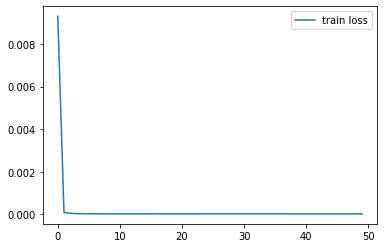

In [71]:
plt.plot(train_losses, label="train loss") 
plt.legend() 

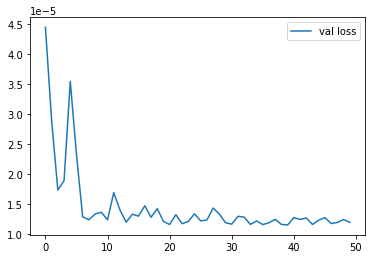

In [72]:
plt.plot(val_losses, label="val loss") 
plt.legend() 

In [73]:
# load test model 
test_model = TFN(n_var_past_cont = features,
                 n_var_future_cont = 0, 
                 n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
                 n_var_future_disc = [60, 24, 32, 13],
                 dim_model = 160)  

checkpoint = torch.load("TFT_feature_engineered_5mins_less_features.pt") 

test_model.load_state_dict(checkpoint)

test_model.eval() 

test_model.cuda() 

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=8640, out_features=54, bias=True)
      (fc1): Linear(in_features=8640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=54, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=54, out_features=54, bias=True)
        (fc2): Linear(in_features=54, out_features=54, bias=True)
      )
      (norm): LayerNorm((54,), eps=1e-05, elementwise_aff

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

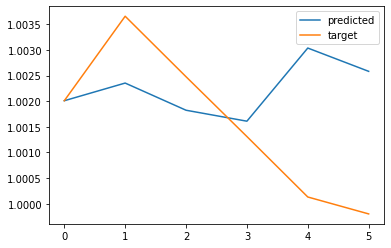

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

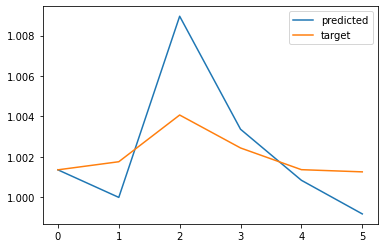

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

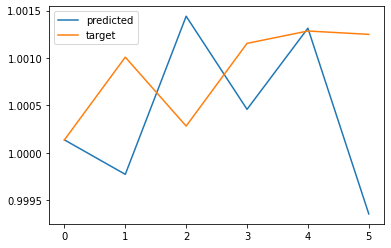

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

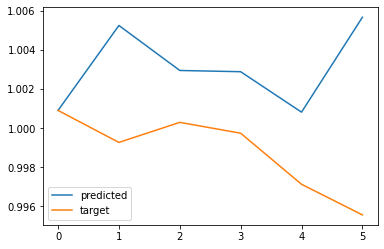

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

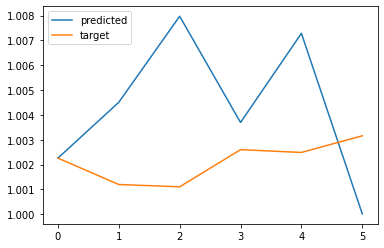

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

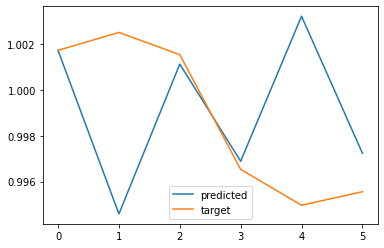

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

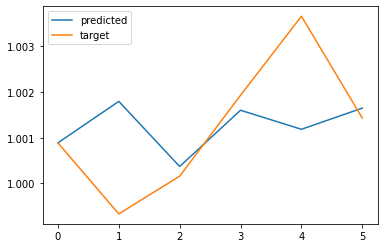

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

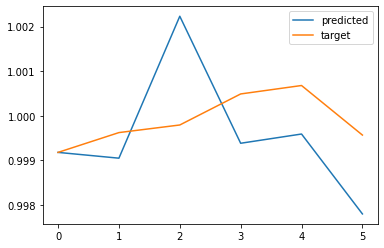

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

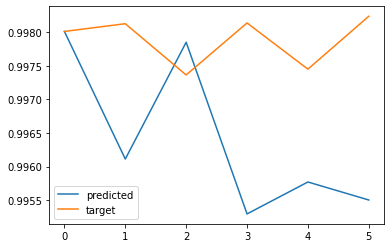

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

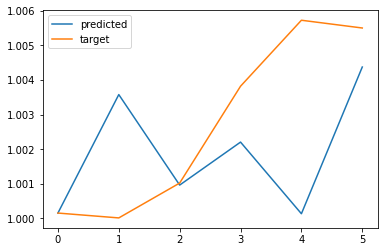

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

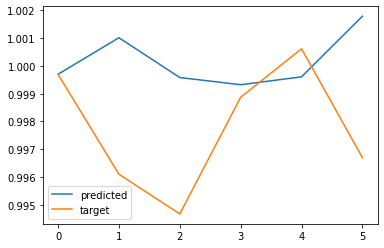

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

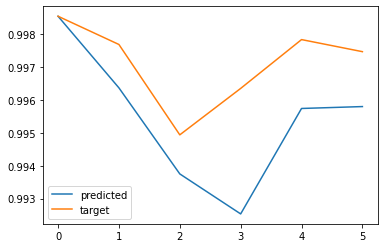

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

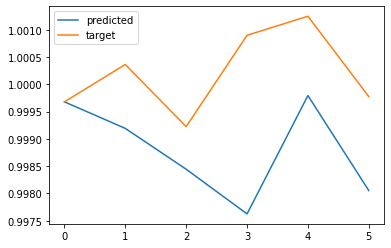

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

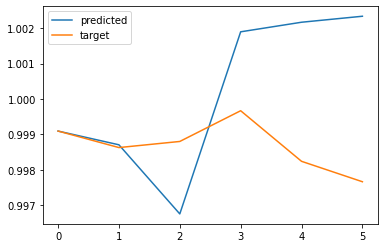

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

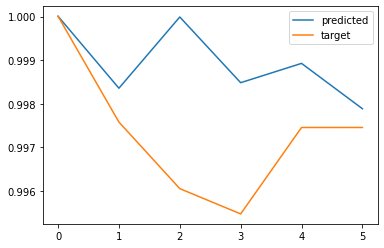

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

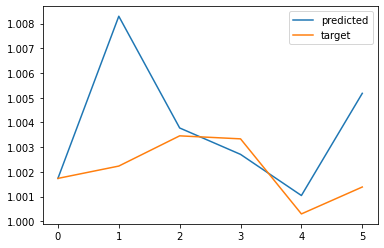

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

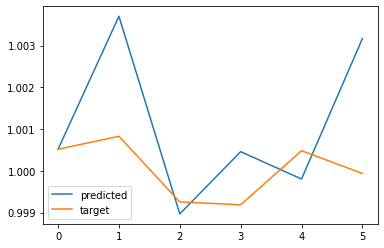

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

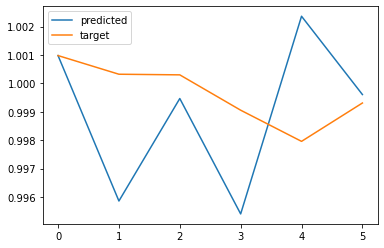

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

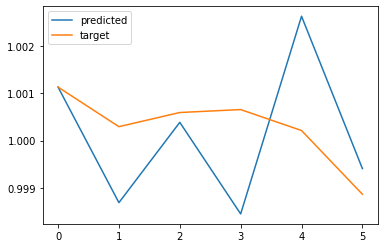

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

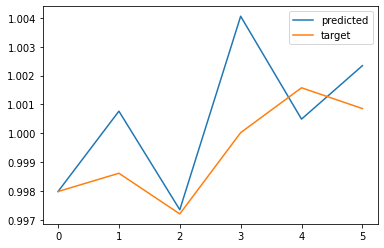

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

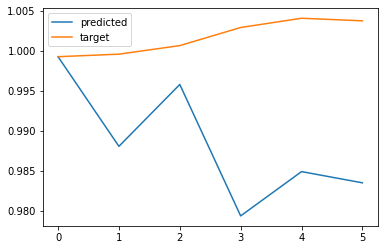

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

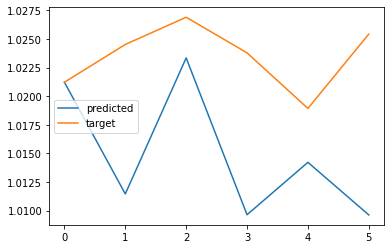

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

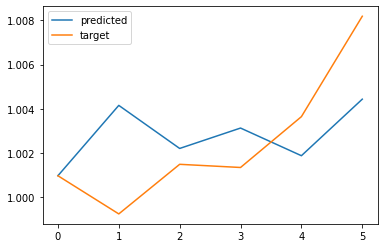

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

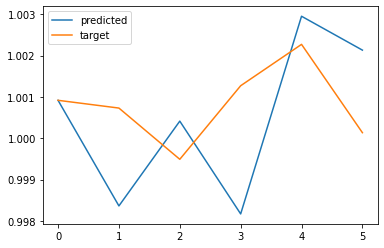

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

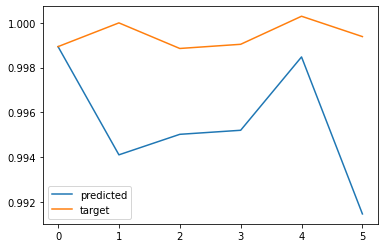

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

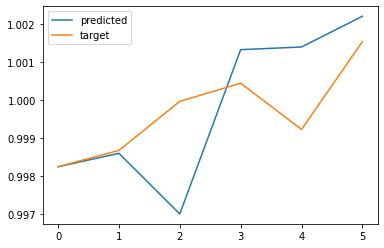

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

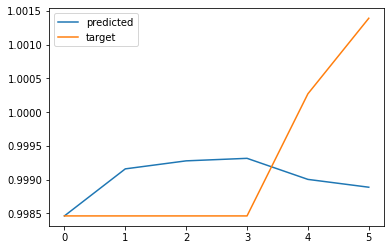

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

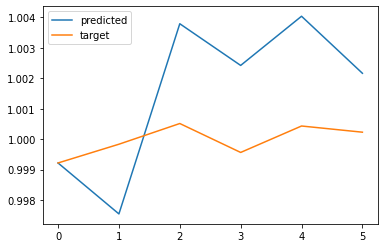

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

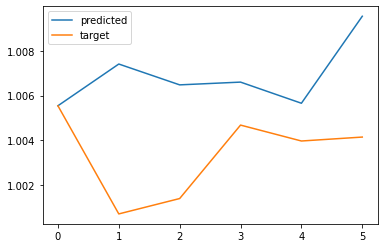

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

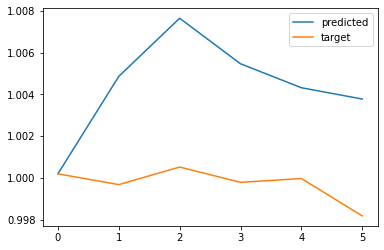

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

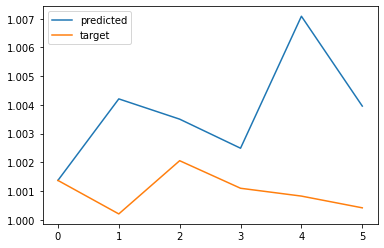

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

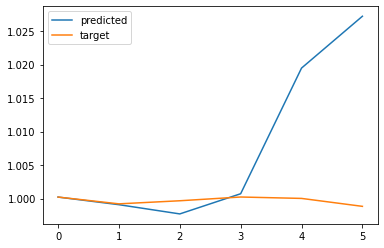

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

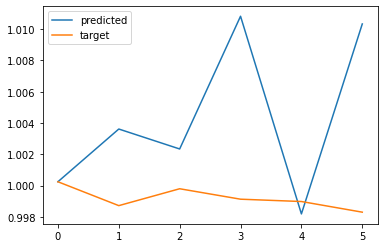

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

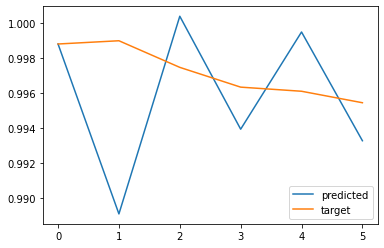

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

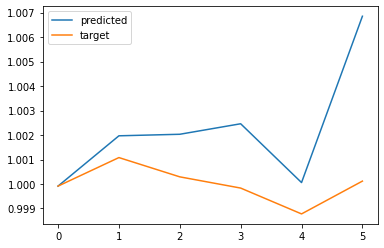

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

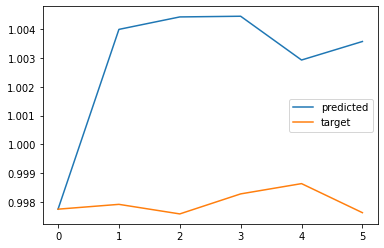

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

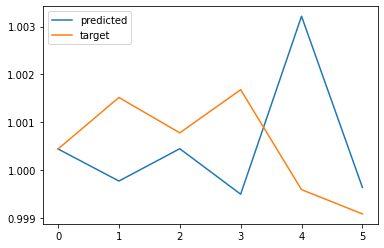

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

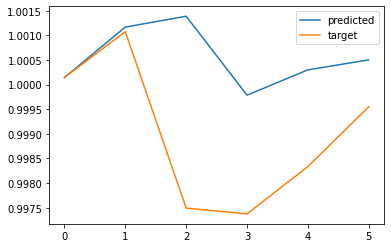

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

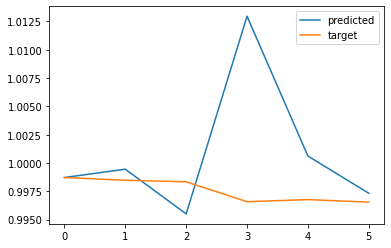

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

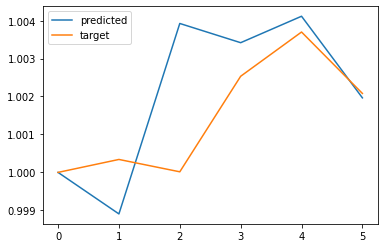

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

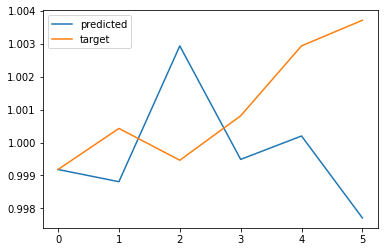

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

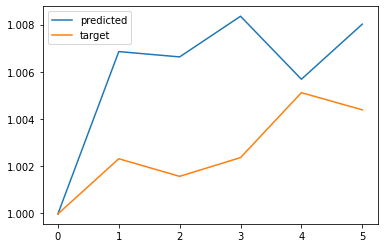

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

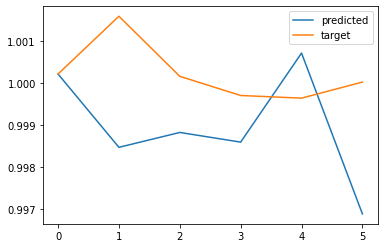

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

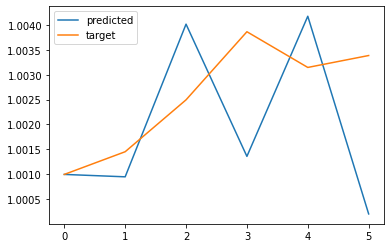

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

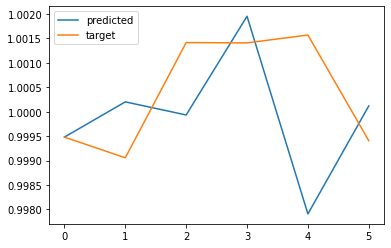

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

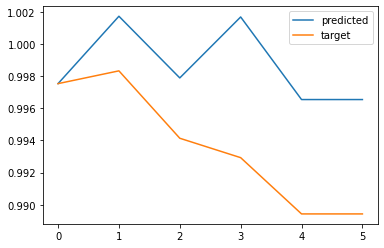

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

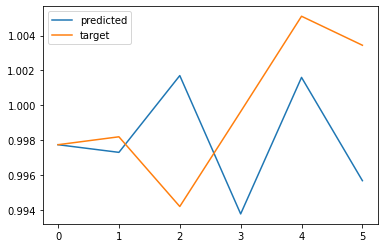

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

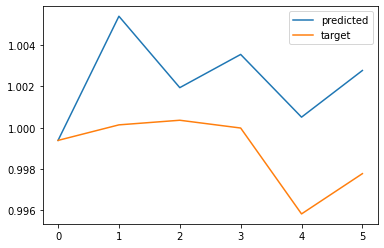

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

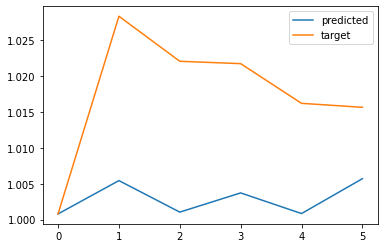

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

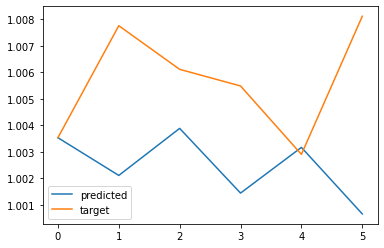

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

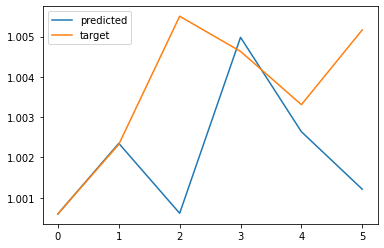

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

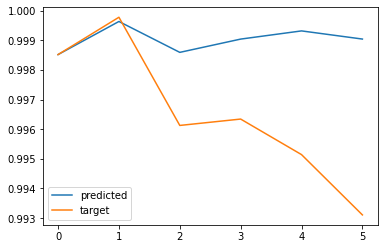

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

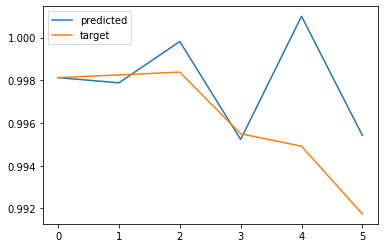

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

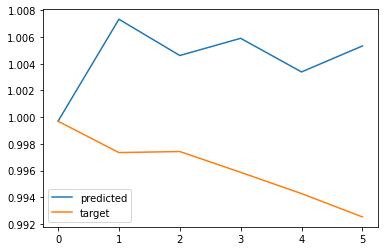

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

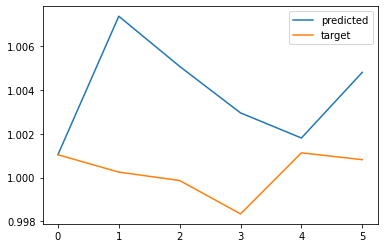

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

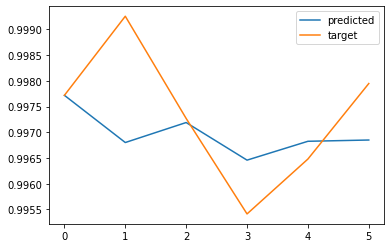

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

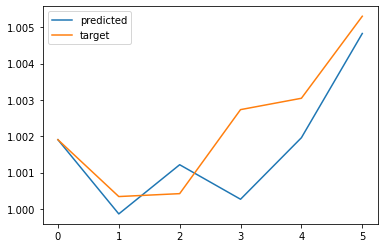

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

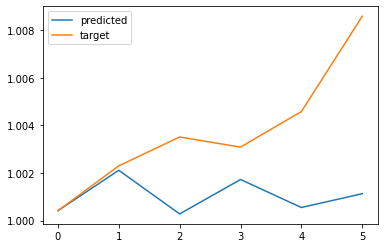

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

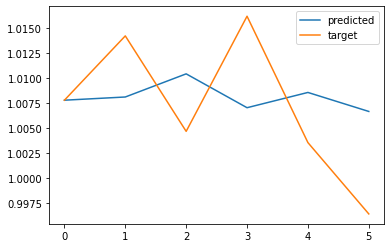

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

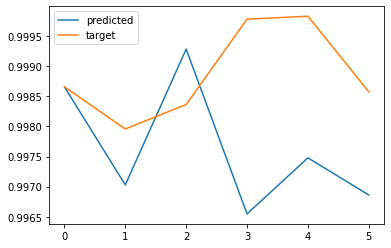

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

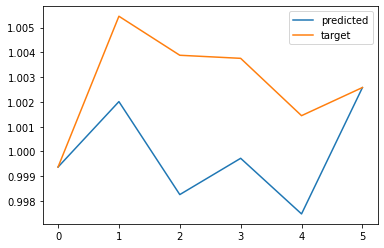

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

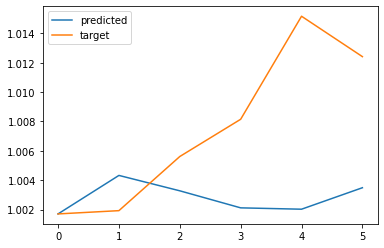

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

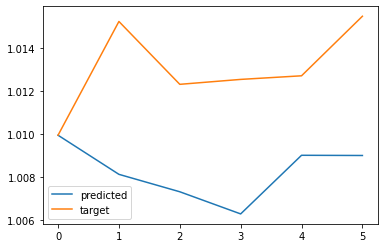

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

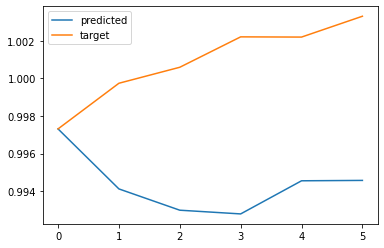

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

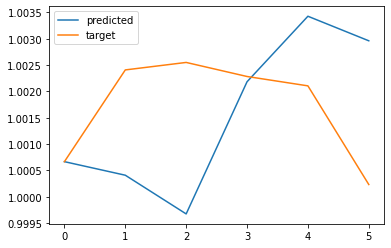

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

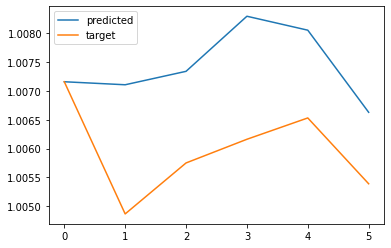

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

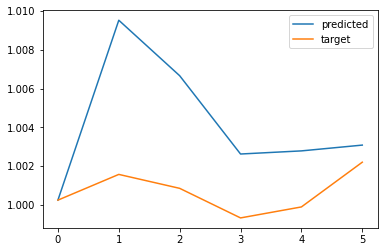

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

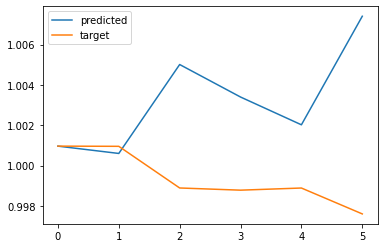

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

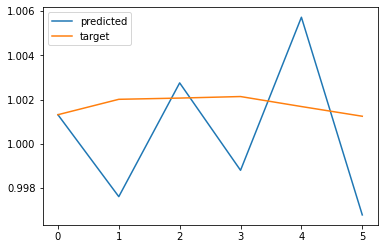

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

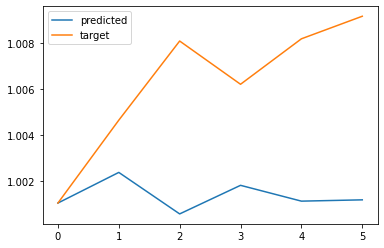

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

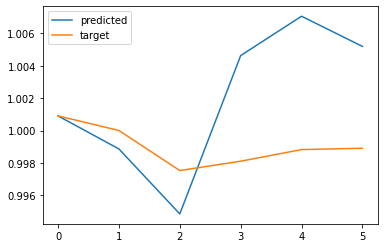

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

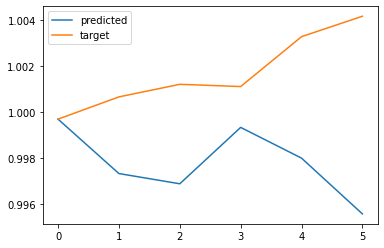

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

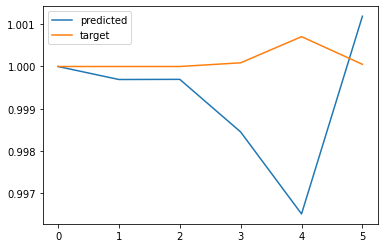

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

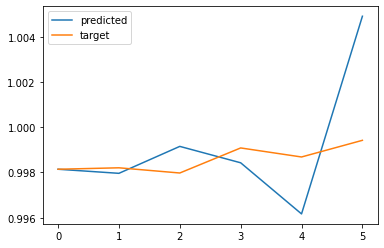

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

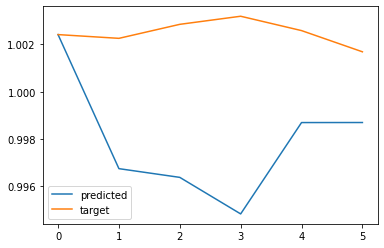

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

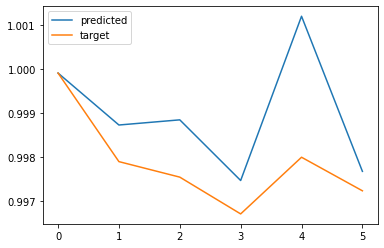

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

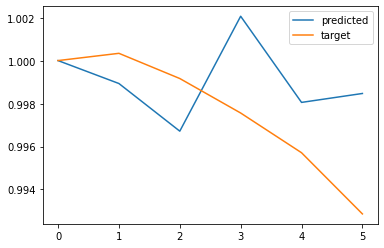

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

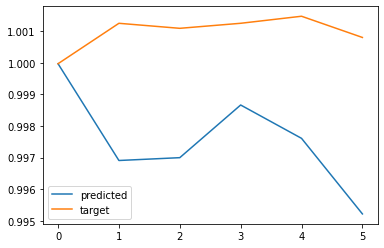

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

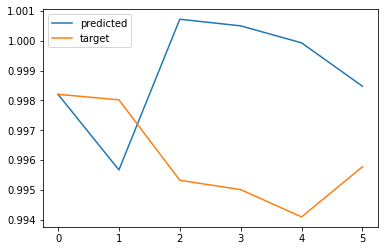

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

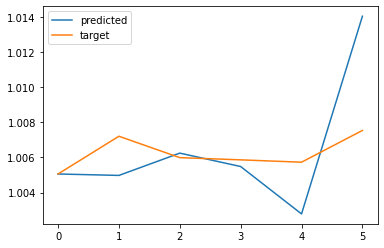

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

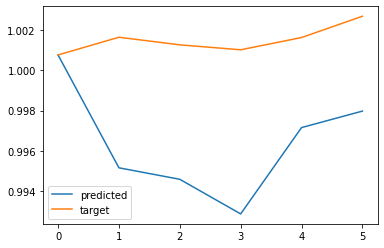

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

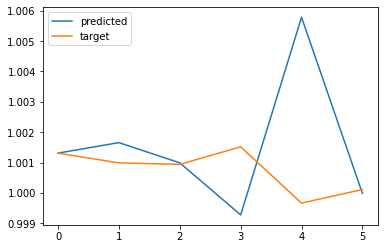

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

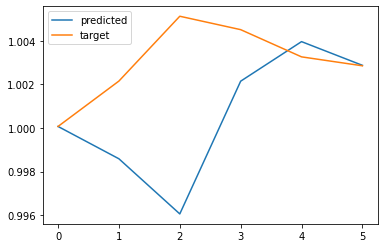

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

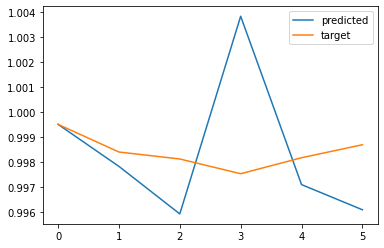

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

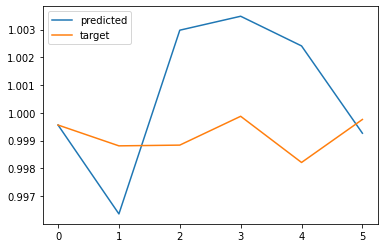

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

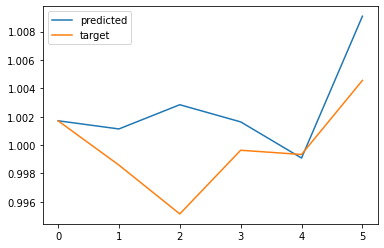

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

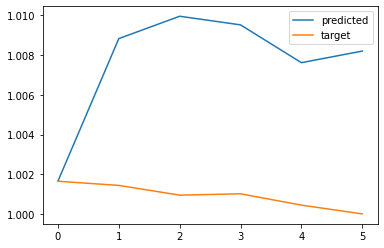

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

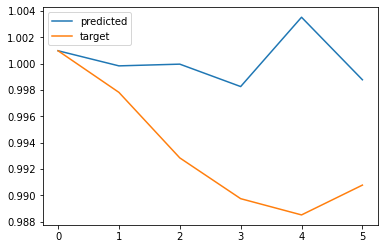

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

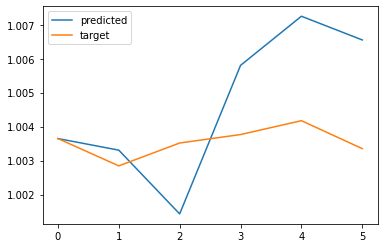

In [76]:
acc = 0 
total = 0 

all_cols = val_df.columns 

for batch in val_dataloader:
    past_cont = batch['past_cont'].to(device) 
    past_disc = batch['past_disc'].to(device) 
    target_seq = batch['target_seq'].to(device) 
    future_disc = batch['future_disc'].to(device)
        
    past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
    future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
    test_model.reset(batch_size=past_cont.shape[0], gpu=True) 
    with torch.no_grad():
        net_out, vs_weights = test_model(past_cont, past_disc, None, future_disc)  
    
    predicted = net_out[0,:,:].detach().cpu().numpy() 
    actual = target_seq[0,:,:].detach().cpu().numpy() 
    
    diff = actual[0] - predicted[0] 
    predicted += diff 
        
    # calculate accuracy 
    for i in range(past_cont.shape[0]): 
        pred_seq = net_out[i,:,:].detach().cpu().numpy() 
        actual_seq = target_seq[i,:,:].detach().cpu().numpy() 
        diff = actual_seq[0] - pred_seq[0] 
        pred_seq += diff 
        for j in range(1,6): 
            actual_diff = actual_seq[j] - actual_seq[j-1] 
            pred_diff = pred_seq[j] - pred_seq[j-1] 
            if (actual_diff >= 0 and pred_diff >= 0) or (actual_diff < 0 and pred_diff < 0):
                acc += 1
            total += 1 
            
    plt.plot(predicted, label="predicted") 
    plt.plot(actual, label="target")
    plt.legend() 
    plt.show() 
                                    

In [77]:
print("Total Accuracy = {:.2f}%".format(acc / total * 100))

Total Accuracy = 50.72%
